# CAM304

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Rede de Convolução / Visão Computacional

### Prof. Eduardo Luz / Eduluz@ufop.edu.br

Objetivos:

- Aplicação de filtros em imagens por meio de convolução
- Entendimento do uso de stride, padding e pooling
- Modelagem de uma rede de convolução para o problema de rec. de face da AT&T
- Uso do VGG pr-e-treinado como um extrator de caracterĩsticas
- Uso do MobileNet pré-treinado para classificação de faces : transferência de aprenzagem
- Notebook baseado em tensorflow e Keras.

Data da entrega : a ser definido

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Crie um repositório no github para o grupo e me convide como colaborador (eduluzufop). Por fim, me envie o link do github. 


# 1. Aplicando filtros e entendendo padding, stride e pooling (20pt)

## 1.1. Importando pacotes e montando o drive

In [34]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import tensorflow.keras
keras = tensorflow.keras
from keras import layers, models, losses, datasets
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
import os
import skimage
from skimage import io
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize



In [35]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1.2. Carregando uma imagem

Carregue um imagem do disco, para usar como exemplo.

sample image shape:  (512, 512, 3)


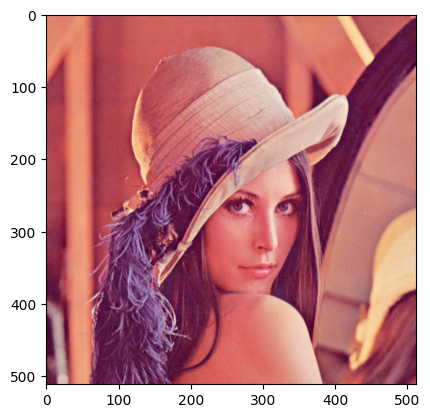

In [36]:
# carrega imagem de exemplo
sample_image = imread("Lenna.png")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

In [37]:
# veja o shape da imagem
sample_image.shape

(512, 512, 3)

## 1.3. Criando e aplicando um filtro com convolução

Utilize o tf/Keras para aplicar o filtro. Observe que nesta etapa não há necessidade de treinamento algum. O código abaixo cria 3 filtros de tamanho 5x5, e adiciona padding de forma a manter a imagem de saída (filtrada) do mesmo tamanho da imagem de entrada (padding ="same").

In [38]:
#cria um objeto sequencial com apenas uma camada de convolução do tipo tf.keras.layers.Conv2D
conv = Sequential([
    Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3))
])
conv.output_shape

(None, None, None, 3)

In [39]:
conv.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, None, None, 3)     228       
                                                                 
Total params: 228 (912.00 Byte)
Trainable params: 228 (912.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# com TF/keras, as convoluções esperam vetores no formato : (batch_size, dim1, dim2, dim3). Ou seja, a primeria posição é o tamanho do lote. 
# Uma imagem isolada é considerada um lote de tamanho 1, portanto, deve-se expandir mais uma dimenão do tensor.
img_in = np.expand_dims(sample_image, axis = 0) 
img_in.shape

(1, 512, 512, 3)

Agora, pode-se aplicar a convolução. Aplique a convolução na imagem de exemplo (expandida) e verifique o tamanho da imagem resultante (img_out). Use a função predict do objeto conv para aplicar a convolução.

In [41]:
img_out = conv(img_in)
img_out.shape

TensorShape([1, 512, 512, 3])

Plote as imagens lado a lado e observe o resultado. O parâmetro "same" no padding aplica um padding automático no sentido de garantir que a saída tenha o mesmo tamanho da entrada.
Lembre-se que o padding adiciona zeros nas bordas da imagem, antes da aplicação da convolução.

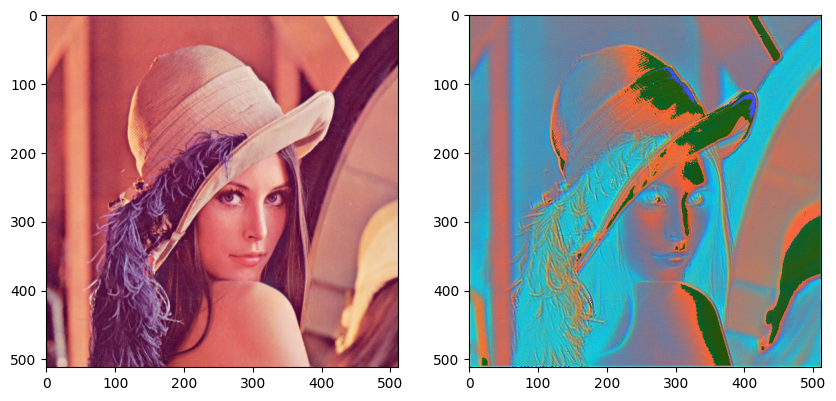

In [42]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax1.imshow(img_out[0].numpy().astype('uint8'));

Repita o mesmo procedimento, trocando padding de 'same' para 'valid', usando apenas um filtro.

In [43]:
conv2 = Sequential([
    Conv2D(filters=1, kernel_size=(5, 5), padding="valid",
           input_shape=(None, None, 3))
])
conv2.output_shape

(None, None, None, 1)

In [44]:
conv2.summary() # 1 filtro 5x5x3 ... a profundidade do filtro é de acordo com a entrada. 5x5x3 = 75; Não esqueça do bias!

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, None, None, 1)     76        
                                                                 
Total params: 76 (304.00 Byte)
Trainable params: 76 (304.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
img_out = conv2(img_in)
img_out[0].shape

TensorShape([508, 508, 1])

Plote as duas imagens lado a lado

In [46]:
#  Como tivemos que expandir a primeira dimensao para aplicar a convolução, podemos remover a dimensão unitária para plotar a imagem, usando a função squeeze()
i = img_out[0].numpy().squeeze()
i.shape

(508, 508)

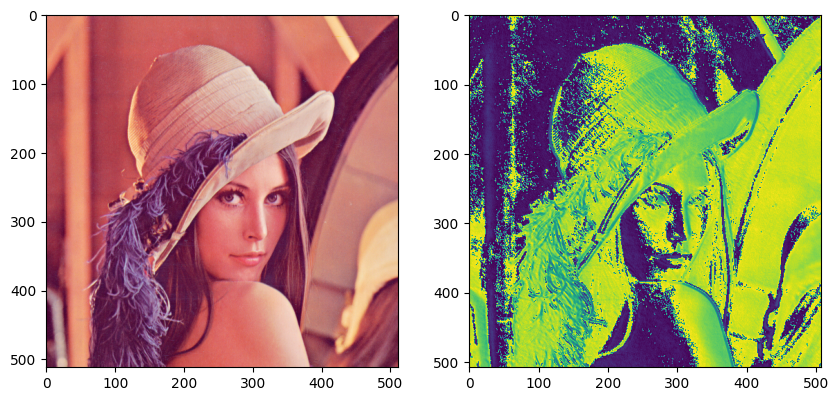

In [47]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
i = img_out[0].numpy().squeeze()
ax1.imshow(i.astype('uint8'));

## 1.4. Inicializando os filtros na mão


A função abaixo inicializa um array de dimensões 5,5,3,3 com todas as posições zero, exceto as posições 5,5,0,0 , 5,5,1,1 e 5,5,2,2 que recebem o valor 1/25.

In [48]:
def my_filter(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype=np.float32)
    array[:, :, 0, 0] = 1/25
    array[:, :, 1, 1] = 1/25
    array[:, :, 2, 2] = 1/25
    return array
my_filter()

array([[[[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]],

        [[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]],

        [[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]],

        [[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]],

        [[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]]],


       [[[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]],

        [[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]],

        [[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]],

        [[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]],

        [[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]]],


       [[[0.04, 0.  , 0.  ],
         [0.  , 0.04, 0.  ],
         [0.  , 0.  , 0.04]],

        [[0.04, 0

In [49]:
# transposição apenas para ajudar na visualização
np.transpose(my_filter(), (2, 3, 0, 1))

array([[[[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]]],


       [[[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
      

In [50]:
# a função definida acima é usada para carregar valores nos filtros. 
# use a função my_filter() para pre-inicializar os filtros do objeto conv3. 
# 
conv3 = Sequential([
     Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3), kernel_initializer=my_filter)
])
conv3.output_shape

(None, None, None, 3)

## 1.5. Plote e observe o que aconte com a imagem (1pt)



Foi observada uma redução da nitidez na imagem.

1/1 [==============================] - 0s 104ms/step


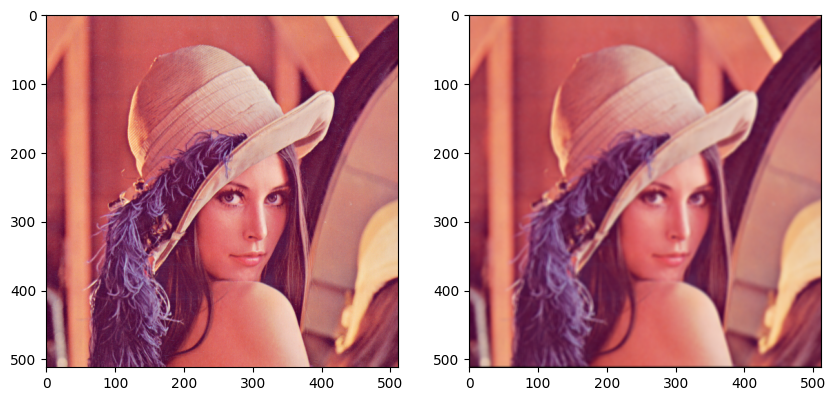

In [51]:
# observe o que aconte com a imagem
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(conv3.predict(img_in)[0].astype('uint8'))

### Responda

**ToDo** : Descreva suas observações sobre a imagem anterior.

*A aplicação dos filtros com padding same mantem a dimensão original da imagem.*
*Já os valores de inicialiação de 1/25 nas dimensões 0 e 1 reduzem a nitidez da imagem. Isso acontece pois cada canal está tendo o valor do seu pixel reduzido em 25 vezes, de forma independente, resultando em suavizações nas variações dos valores dos pixels*

## 1.6. Filtros de borda (5pt)

**ToDo** : Crie uma nova função para gerar um filtro de borda nos 3 canais da imagem de entrada. O filtro deve ser 3x3 e ter o formato [[0 0.2 0] [0 -0.2 0] [0 0 0]] (2pt)

In [52]:
def my_new_filter(shape=(3, 3, 3, 1), dtype=None): #(n linhas, nº colunas, nº canais, nº filtros)
    array = np.zeros(shape=shape, dtype=np.float32)
    array[0, 1, :, 0] = 2/10
    array[1, 1, :, 0] = -2/10
    return array

In [53]:
np.transpose(my_new_filter(), (2, 3, 0, 1))

array([[[[ 0. ,  0.2,  0. ],
         [ 0. , -0.2,  0. ],
         [ 0. ,  0. ,  0. ]]],


       [[[ 0. ,  0.2,  0. ],
         [ 0. , -0.2,  0. ],
         [ 0. ,  0. ,  0. ]]],


       [[[ 0. ,  0.2,  0. ],
         [ 0. , -0.2,  0. ],
         [ 0. ,  0. ,  0. ]]]], dtype=float32)

Inicialize o objeto conv4 com seu novo filtro e aplique na imagem de entrada

In [54]:
conv4 = Sequential([
    Conv2D(filters=1, kernel_size=(3, 3), padding="same",
           input_shape=(None, None, 3), kernel_initializer=my_new_filter)
])
conv4.output_shape

(None, None, None, 1)

1/1 [==============================] - 0s 153ms/step


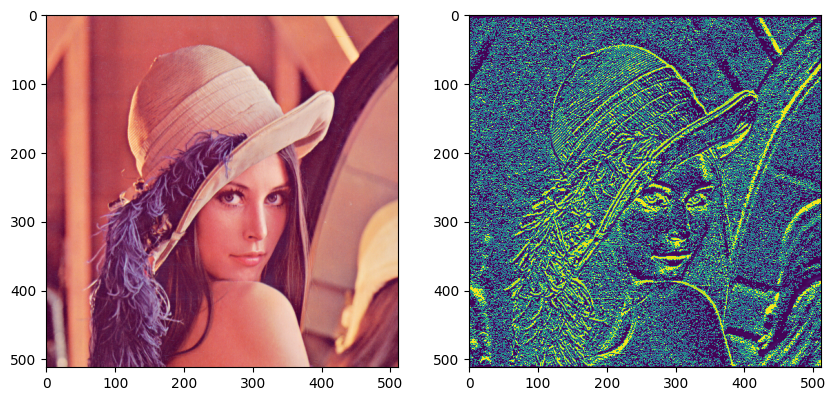

In [55]:
# Plote as duas iamgens lado a lado (filtrada e não filtrada)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(conv4.predict(img_in)[0].astype('uint8'));

## 1.7. Pooling (14pt)



Aplique um max-pooling na imagem, com uma janela de 2x2. Faça com stride de 2 e observe o resultado na imagem de saída. 

In [56]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)

max_pool = Sequential([MaxPool2D(pool_size = (2,2), strides=2, input_shape=(None, None, 3))])


In [57]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool.predict(img_in) # aplica o pooling

1/1 [==============================] - 0s 114ms/step


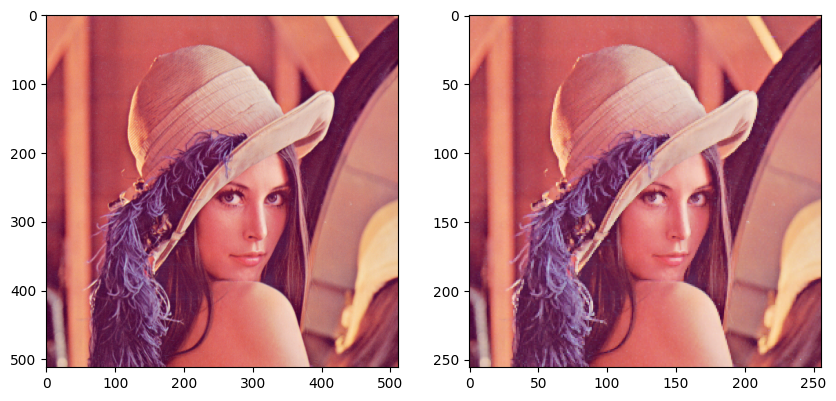

In [58]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 4, repita o processo e observe o resultado na imagem de saída.




In [59]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 4

max_pool2 = Sequential([MaxPool2D(pool_size = (2,2), strides=4, input_shape=(None, None, 3))])

In [60]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool2.predict(img_in) # aplica o pooling

1/1 [==============================] - 0s 128ms/step


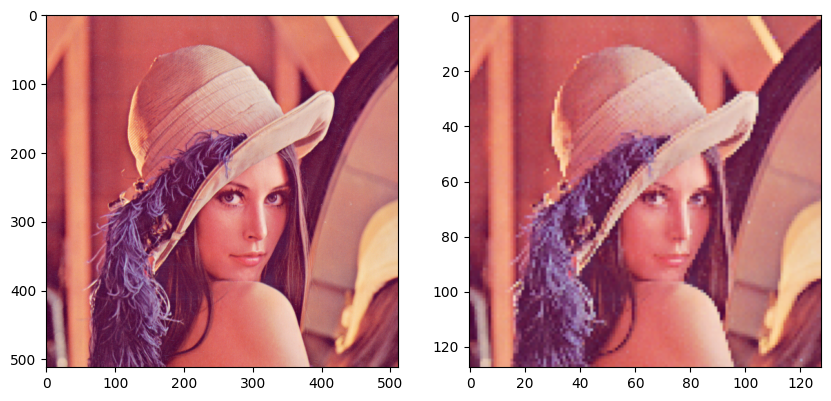

In [61]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 8, repita o processo e observe o resultado na imagem de saída. A

In [62]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 4

max_pool3 =Sequential([MaxPool2D(pool_size = (2,2), strides=8, input_shape=(None, None, 3))])

In [63]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool3.predict(img_in) # aplica o pooling

1/1 [==============================] - 0s 209ms/step


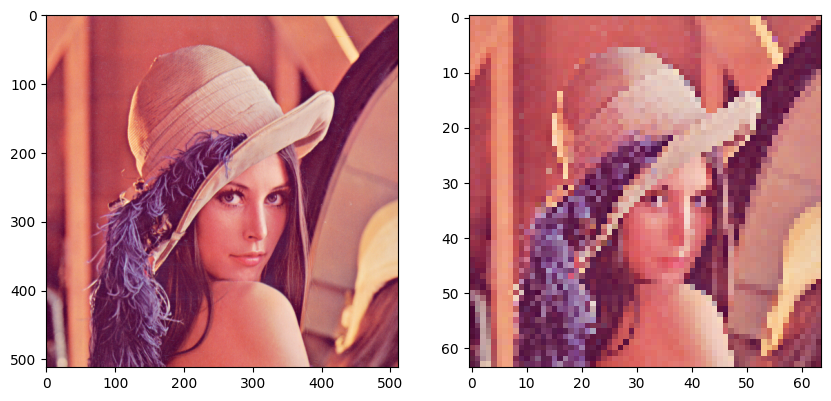

In [64]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

### Responda

**ToDo** - Descreva o que aconteceu com o aumento do stride.

*O aumento do stride significa que o filtro salta mais de um pixel ao ser deslizado sobre a imagem. Dessa forma, com o seu aumento, as dimensões da imagem de saída são reduzidas. De fato, a imagem com stride 2 tem dimensões(h x w) reduzidas pela metade, e o de stride 8 tem dimensões reduzidas por 8.*

*Outro efeito do aumento do stride é a redução da resolução, já que o filtro amostra menos pixels para representá-los.A imagem gerada pela aplicação de um filtro com stride 8 tem resolução visivelmente inferior à original.*

# 2. Reconhecimento de Faces usando uma rede de convolução (20pt)




O objetivo desta etapa é classificar faces na base ORL (AT&T) Database (40 individuos x 10 imagens, de resolução 92x112 pixels e 256 níveis de cinza).

Baixe as imagens no site http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html ou da pasta dataset do Drive.

## 2.1. Preparando os dados (5pt)

In [65]:
# carregue as imagens 

# inicializa matrizes X e y
X = np.empty([400, 112, 92]) # 40 classes com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "faces"
i=0
class_id = 0
for f in os.listdir(imgs_path): 
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                X[i, :, :] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id        
                i = i + 1
 

print("dimensões da matriz X = " , X.shape)

dimensões da matriz X =  (400, 112, 92)


In [66]:
# Divida os dados em treino e teste (70%-30%) com a função train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3) 

In [67]:
X_train.shape

(280, 112, 92)

In [68]:
X_test.shape

(120, 112, 92)

## 2.2. Implementando a rede (15pt)

Implemente uma rede de convolução simples, contendo 3 camadas de convolução seguidas de camadas max-pooling. Duas camadas densas (totalmente conectadas) no final e por fim uma camada com ativação softmax para a classificação. Escolha filtros de tamanhos variados : (3,3) ou (5,5). Para cada camada, crie de 32 a 96 filtros. 
Na camada densa, use de 64 a 200 neurônios.

Use o comando model.summary() para conferir a arquitetura. 

In [69]:
# Implementa uma rede de convolução simples, chamada model

input_size = (X.shape[1], X.shape[2],1)
n_classes = 40

model = models.Sequential()
model.add(layers.InputLayer(input_shape = input_size))
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5))) 
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3))) 
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters = 96, kernel_size = (3,3))) 
model.add(layers.Flatten()) 
model.add(layers.Dense(units=64))
model.add(layers.Dense(units=64))
model.add(layers.Dense(units=n_classes, activation="softmax"))
                       
model.summary()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 108, 88, 32)       832       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 44, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 42, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 21, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 19, 96)        55392     
                                                                 
 flatten (Flatten)           (None, 43776)           

Seu modelo deve ter uma saída aproximadamente como abaixo:



```
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_60 (Conv2D)           (None, 110, 90, 32)       320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 55, 45, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 53, 43, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 26, 21, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 24, 19, 64)        36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 29184)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1867840   
_________________________________________________________________
dense_10 (Dense)             (None, 40)                2600      
=================================================================
Total params: 1,926,184
Trainable params: 1,926,184
Non-trainable params: 0
_________________________________________________________________
```



In [70]:
# repare bem o shape de x_train. A priumeira dimensão é o tamanho do lote, a segunda e terceira são referentes ao taamnho das imagens.
# repare que as imagens desta base tem apenas uma banda (escala de cinza) 
X_train.shape

(280, 112, 92)

In [71]:
# Como o tensor acima não contempla o tamanho de canais (no caso , igual a 1), deve-se expandir a última dimensão para deixar a entrada compatĩvel com o que é esperado pelo modelo do tf.keras
X_train_new = np.expand_dims(X_train, axis= 3)
X_test_new = np.expand_dims(X_test, axis= 3)

X_train_new.shape

(280, 112, 92, 1)

In [72]:
# o vetor de rótulos não precisa ter duas dimensões.
y_train_new = y_train.squeeze()
y_test_new = y_test.squeeze()

# e deve ficar na faixa entre 0 e 39
y_train_new = y_train_new - 1 
y_test_new = y_test_new - 1




Compile o modelo usando o método de otimização=adam e função de custo (loss) = sparse_categorical_crossentropy. 

In [73]:
model.compile(optimizer="adam", loss=losses.sparse_categorical_crossentropy, metrics=['acc'])

Treine o modelo por 30 épocas com batch_size = 100.

In [74]:
history = model.fit(x=X_train_new, y=y_train_new, batch_size=100, epochs=30, validation_split=0.15)

Epoch 1/30


3/3 [==============================] - 4s 452ms/step - loss: 966.0804 - acc: 0.0084 - val_loss: 1823.9619 - val_acc: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 324ms/step - loss: 1392.6538 - acc: 0.0336 - val_loss: 768.1567 - val_acc: 0.0476
Epoch 3/30
3/3 [==============================] - 1s 217ms/step - loss: 728.6696 - acc: 0.0462 - val_loss: 395.4757 - val_acc: 0.0476
Epoch 4/30
3/3 [==============================] - 1s 219ms/step - loss: 607.2598 - acc: 0.0252 - val_loss: 668.1898 - val_acc: 0.0238
Epoch 5/30
3/3 [==============================] - 1s 196ms/step - loss: 535.7408 - acc: 0.0336 - val_loss: 275.8953 - val_acc: 0.0714
Epoch 6/30
3/3 [==============================] - 1s 198ms/step - loss: 247.1367 - acc: 0.1387 - val_loss: 156.7104 - val_acc: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 201ms/step - loss: 176.0794 - acc: 0.1681 - val_loss: 112.6564 - val_acc: 0.1905
Epoch 8/30
3/3 [==============================] - 1s 194ms/step - l

O retorno da função fit() é um objeto para armazenar o histõrico do treino.

In [75]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Plote a acurácia e o custo (loss) do treino e da validação.

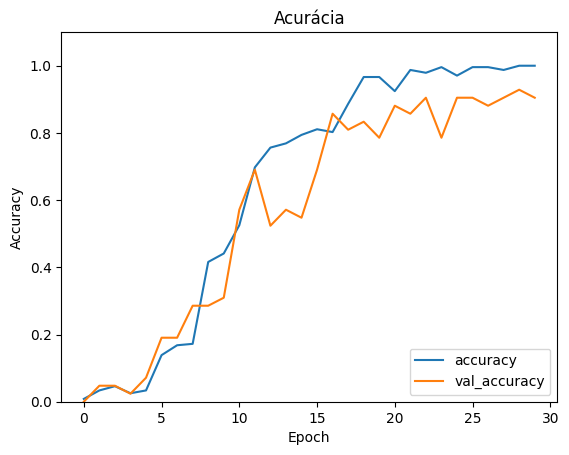

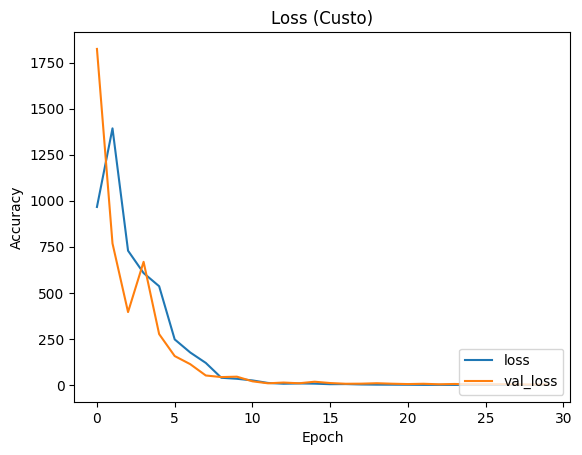

In [76]:
plt.figure(1)
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([00, 1.1])
plt.title('Acurácia')
plt.legend(loc='lower right')

plt.figure(2)
plt.title('Loss (Custo)')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

In [77]:
test_loss, test_acc = model.evaluate(X_test_new,  y_test_new, verbose=2)
print(test_acc)

4/4 - 0s - loss: 11.2179 - acc: 0.6667 - 145ms/epoch - 36ms/step
0.6666666865348816


# 3. Usando um modelo Pré-treinado : VGG (10pt)

Carregando os dados da base AT&T para o VGG. Como a base está em escala de cinza e a entrada do modelo VGG espera uma imagem colorida (RGB), vamos repetir a mesma imagem em cada uma das bandas.

## 3.1. Preparando os dados (2pt)


In [78]:
# inicializa matrizes X e y
X = np.empty([400, 112, 92, 3]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "faces"
i=0
class_id = 0
for f in os.listdir(imgs_path): 
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                # copia msg imagem para os 3 canais
                X[i, :, :,0] = io.imread(os.path.join(imgs_path,f,img_path))
                X[i, :, :,1] = io.imread(os.path.join(imgs_path,f,img_path))
                X[i, :, :,2] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id-1        
                i = i + 1
 
       

In [79]:
# divida em 70% treino e 30% teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3) 
X_train.shape

(280, 112, 92, 3)

Text(0.5, 1.0, 'Classe: 17.0')

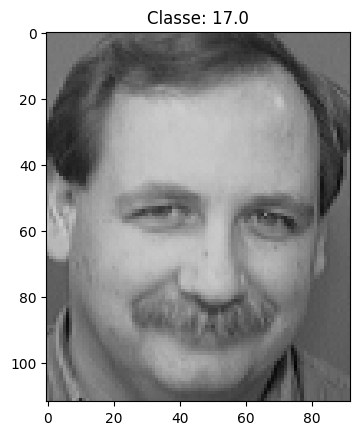

In [83]:
n = 104
img = X_train[n,:,:,:]/255
label = y_train[n,0]
plt.imshow(img)
plt.title(f"Classe: {label}")

## 3.2. Carrando o VGG direto da biblioteca do tensorflow (2pt)

In [84]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br

from tensorflow.keras.applications import VGG19
vgg19 = VGG19()

In [85]:
vgg19.summary() # repare a quantidade de parãmetros!

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Vamos descartar as duas últimas camadas do VGG

In [86]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br
from tensorflow.keras.models import Model

vgg_face_descriptor = Model(inputs=vgg19.layers[0].input, outputs=vgg19.layers[-2].output)


### Responda

**ToDo** - Por que descartamos as duas últimas camadas do VGG?

*O VGG foi treinado com as imagens do Imagenet. Portanto, as duas últimas camadas do VGG foram descartadas pois elas são as camadas "especialistas" no dataset de treinamento, enquanto que as camadas iniciais do VGG atuam como extratoras de features genéricas . Como o objetivo é extrair features para medir a similaridade e não fazer um algoritmo de classificação, por exemplo, descarta-se as últimas camadas.*

## 3.3 Medindo Similaridade

### As funções abaixo servem para medir similaridade entre duas imagens, passando-se um vetor de características.

In [87]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

### A função verifyFace recebe duas imagens e calcula a similaridade entre elas. Se a similaridade for menor que epsilon, afirma-se que as duas imagens são de uma mesma pessa.

In [88]:
epsilon = 0.0042

def verifyFace(img1, img2):
    
    img1_representation = vgg_face_descriptor.predict(img1, steps=None)[0,:]
    img2_representation = vgg_face_descriptor.predict(img2, steps=None)[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Similaridade com distancia do cosseno: ",cosine_similarity)
    print("Similaridade com distancia euclideana: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("Verificado! Mesma pessoa!")
    else:
        print("Não-verificado! Não são a mesma pessoa!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(np.squeeze(img1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(np.squeeze(img2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

### Verificando a similaridade entre imagens (6pt)

Para 4 pares de imagens da base da AT&T e faça uma verificação entre elas, chamando a função verifyFace().

Antes de usar o VGG como um extrator de caracteristicas, normalize os dados dividindo os pixels por 255. Além disso, re-escalone as imagesn para o formato 224x224. Use a biblioteca OpenCV (cv2). 

Faça para os pares : 64 e 33, 3 e 7, 40 e 44, 100 e 200.

1/1 [==============================] - 0s 292ms/step
Similaridade com distancia do cosseno:  0.0077568888664245605
Similaridade com distancia euclideana:  5.8379307
Não-verificado! Não são a mesma pessoa!


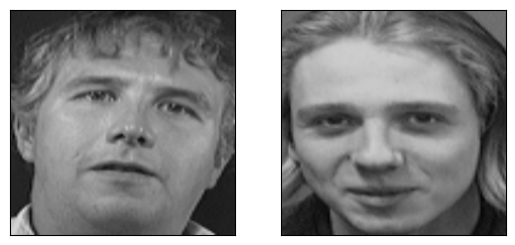

-----------------------------------------
1/1 [==============================] - 0s 315ms/step
Similaridade com distancia do cosseno:  0.0026636123657226562
Similaridade com distancia euclideana:  3.3674662
Verificado! Mesma pessoa!


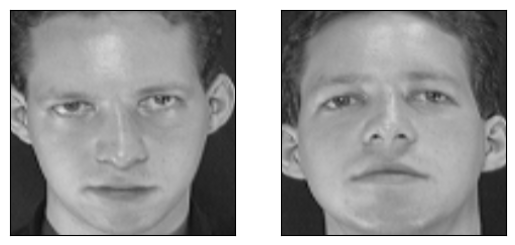

-----------------------------------------
1/1 [==============================] - 0s 267ms/step
Similaridade com distancia do cosseno:  0.004126906394958496
Similaridade com distancia euclideana:  4.268542
Verificado! Mesma pessoa!


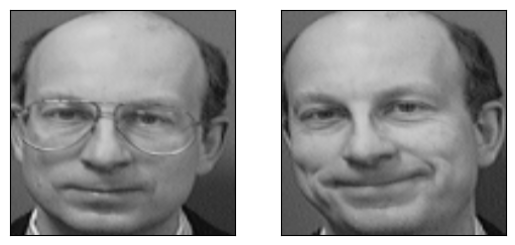

-----------------------------------------
1/1 [==============================] - 0s 289ms/step
Similaridade com distancia do cosseno:  0.010479569435119629
Similaridade com distancia euclideana:  6.80425
Não-verificado! Não são a mesma pessoa!


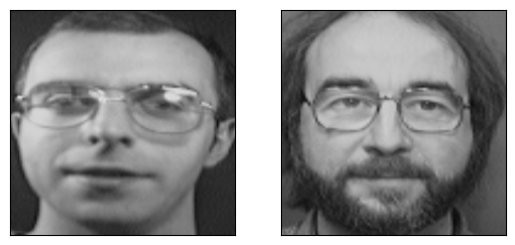

-----------------------------------------


In [89]:
import cv2

img_list = [[64,33],[3,7],[40,44],[100,200]]

for i in range(4):
    index_1 = img_list[i][0]
    index_2 = img_list[i][1]
    img1 = X[index_1,:,:,:]/255 # Normaliza entre 0 e 1 , dividindo por 255
    img2 = X[index_2,:,:,:]/255 # Normaliza entre 0 e 1 , dividindo por 255

    dim=(224,224)
    img1 = cv2.resize(img1, dim) # Redimensiona a imagem para (224,224) 
    img2 = cv2.resize(img2, dim) # Redimensiona a imagem para (224,224) 

    img1 = np.expand_dims(img1, axis= 0) # Expande a primeira dimensão
    img2 = np.expand_dims(img2, axis= 0) # Expande a primeira dimensão

    verifyFace(img1, img2)

# 4. Transferência de aprendizado (50pt)


Estude o tutorial do [link](https://www.tensorflow.org/tutorials/images/transfer_learning) e aplique o mesmo procedimento para ajustar um modelo previamente treinado com imagens da imagenet. 
Use o MobileNetV2 como modelo base.

Todo: Faça o procedimento em duas etapas:


1.   Congele todas as camadas exceto as novas que você adicinou ao modelo. Treine.
2.   Libere todas as camadas paar o treinamento e treine novamente com um Learning Rate bem pequeno (um décimo do realizado no ítem 1).

In [90]:
# Usando o mobileNet, as imagens devem ter entrada de 160x160x3 e normalizadas entre -1 e 1. 
# Use a funçao abaixo para fazer o trabalho, conjuntamente com tf.data.Dataset.from_tensor_slices

IMG_SIZE = (160,160) # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE))
  return image, label

In [91]:
X_train.shape


(280, 112, 92, 3)

In [92]:
# Tensorflow tem funções especĩficas para carregar os dados. Veja tf.data.Dataset

raw_train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
raw_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))


In [93]:
train = raw_train.map(format_example)
test = raw_test.map(format_example)
train.element_spec

(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(1,), dtype=tf.float64, name=None))

Seus dados devem ter o formato :



```
TensorShape([Dimension(280), Dimension(160), Dimension(160), Dimension(3)])

```



In [94]:
BATCH_SIZE = 18

train, val_dataset = tf.keras.utils.split_dataset(train, left_size=0.9, shuffle=True)
 
train_batches = train.shuffle(252).batch(BATCH_SIZE)
test_batches = test.batch(15)
val_batches = val_dataset.batch(28)

## 4.1. Execute os passos (35pt):




1. Carregue o modelo pré-treinado do MobileNet, remova a última camada. 
2. Adicione uma camdada de Global Average Pooling 2D (GAP)
3. Adicione uma camada densa para ajustar ao seu número de classes e use ativação softmax
4. Use função de custo loss='sparse_categorical_crossentropy'
5. Dentre os dados de treinamento, reserve 10% para validação do modelo.
6. Treine por 10 épocas.
7. Plote os gráficos de custo do treino e validação


### Procedimento 1  - Congelando todas as camadas exceto as novas adicionadas ao modelo

In [95]:
def train_basemodel_frozen (verbose = 0, base_learning_rate = 0.001, epochs = 10, n_classes = 40, show_summaries = True):
    IMG_SHAPE = IMG_SIZE + (3,)
    
    #1 - Carregando o modelo pré-treinado do MobileNet, remoção da última camada. 
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False #Freezing layers from base model

    # 2. Adicionando uma camada de Global Average Pooling 2D (GAP)
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    # 3. Adicionando uma camada densa para ajustar ao seu número de classes e com uma ativação softmax
    prediction_layer = tf.keras.layers.Dense(units=n_classes, activation="softmax")  

    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = base_model(inputs, training=False)
    x = global_average_layer(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    if show_summaries == True:
        base_model.summary()
        model.summary()

    # 4. Compilação do modelo, função de custo loss='sparse_categorical_crossentropy'
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['acc'])
    
    # 5. Treinamento com 10% da base de treinamento para validação do modelo.
    history = model.fit(train_batches,
                        epochs=epochs,
                        validation_data = val_batches,
                        verbose=verbose)
    return history, base_model, model

In [100]:
base_learning_rate = 0.0005
initial_epochs = 10 #6. Treinamento por 10 épocas.
model_history, base_model, model = train_basemodel_frozen(base_learning_rate=base_learning_rate, epochs=initial_epochs, verbose=1)

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [97]:
# 7. Plotando os gráficos de custo do treino e validação
def plot_model_performance(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']


    plt.figure(1)
    plt.plot(history.history['acc'], label='accuracy')
    plt.plot(history.history['val_acc'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylim([00, 1.1])
    plt.title('Acurácia')
    plt.legend(loc='lower right')

    plt.figure(2)
    plt.title('Loss (Custo)')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

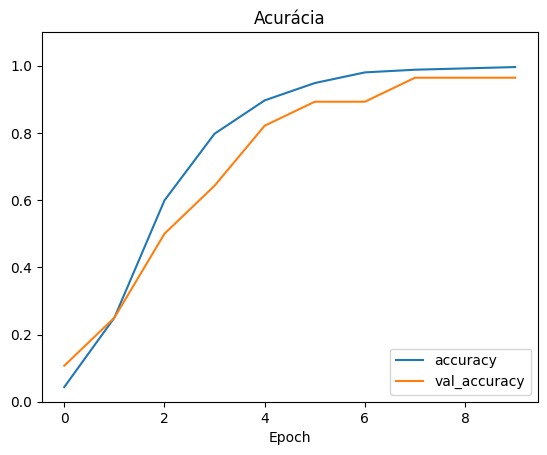

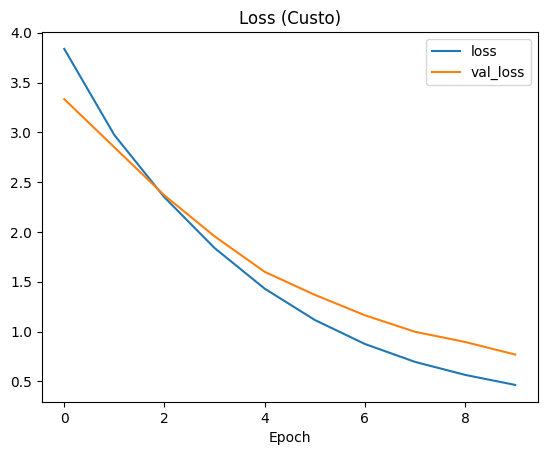

In [101]:
plot_model_performance(model_history)

### Procedimento 2  - Liberando todas as camadas para o treinamento e treinando novamente com um Learning Rate pequeno

In [102]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 0 #Definindo todas as camadas como treináveis
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
model.summary()

Number of layers in the base model:  154
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 40)                51240     
                                                                 
Total params: 2309224 (8.81 MB)
Trainable params: 2275112 (8.68 MB)
Non-trainable params: 34112 (133.25 KB)
__________________________________________

In [103]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['acc'])

In [104]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_batches)

Epoch 10/20


14/14 [==============================] - 28s 500ms/step - loss: 0.1936 - acc: 0.9722 - val_loss: 0.1901 - val_acc: 0.9643
Epoch 11/20
14/14 [==============================] - 5s 353ms/step - loss: 0.0282 - acc: 1.0000 - val_loss: 0.2936 - val_acc: 0.9286
Epoch 12/20
14/14 [==============================] - 5s 361ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.1720 - val_acc: 0.9643
Epoch 13/20
14/14 [==============================] - 8s 582ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.2382 - val_acc: 0.9286
Epoch 14/20
14/14 [==============================] - 6s 381ms/step - loss: 9.2364e-04 - acc: 1.0000 - val_loss: 0.2442 - val_acc: 0.9286
Epoch 15/20
14/14 [==============================] - 5s 329ms/step - loss: 6.3732e-04 - acc: 1.0000 - val_loss: 0.2244 - val_acc: 0.9643
Epoch 16/20
14/14 [==============================] - 5s 331ms/step - loss: 5.1550e-04 - acc: 1.0000 - val_loss: 0.2085 - val_acc: 0.9643
Epoch 17/20
14/14 [==============================] - 5s 327ms/step -

In [108]:
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']



acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

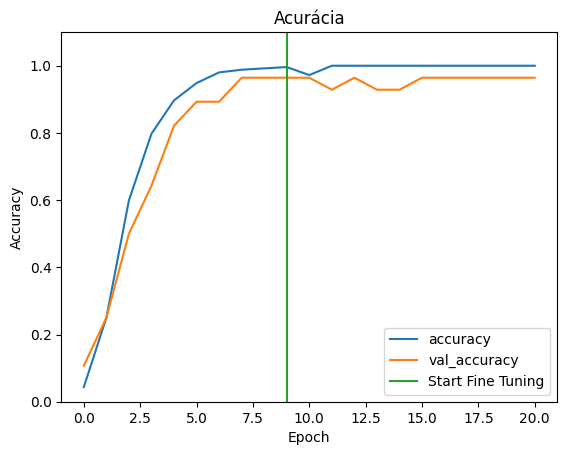

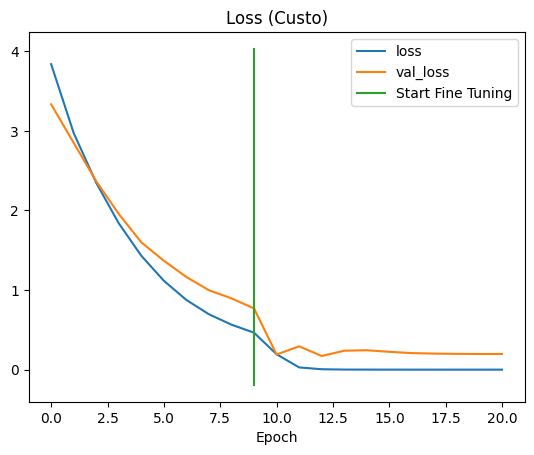

In [109]:
plt.figure(1)
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([00, 1.1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.title('Acurácia')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.title('Loss (Custo)')
plt.legend(loc='upper right')

In [110]:
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 76ms/step - loss: 0.1424 - acc: 0.9750
Test accuracy : 0.9750000238418579


Predictions:
 [27 36  2 36  5  8  6 37 11 13 18 36 18 17  7]


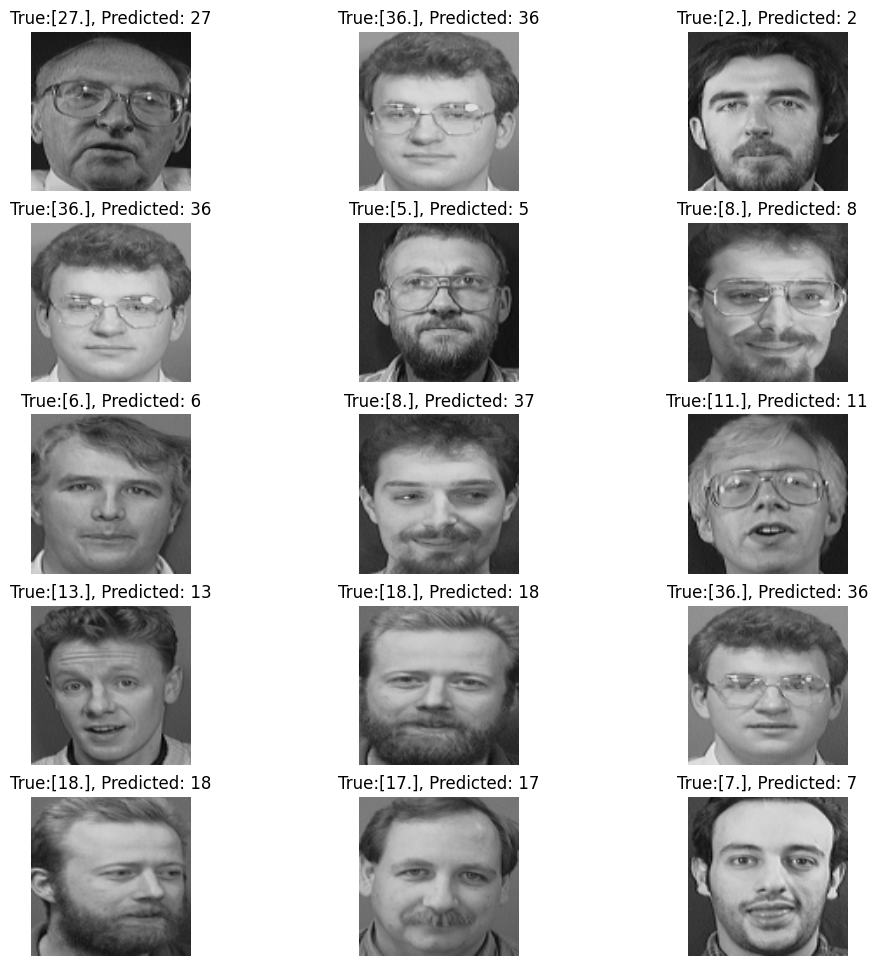

In [111]:
# Teste do modelo
image_batch, label_batch = test_batches.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)


pred_classes = tf.argmax(predictions, axis=1)
pred_classes = pred_classes.numpy()
print('Predictions:\n', pred_classes)

image, image_label = next(iter(test_batches))

plt.figure(figsize=(12, 12))
for i in range(15):
  ax = plt.subplot(5, 3, i + 1)
  image2 = (image[i]+1)*127.5 
  plt.imshow(image2/255)
  plt.title(f"True:{label_batch[i]}, Predicted: {pred_classes[i]}")
  plt.axis("off")

## 4.2. Fazendo testes (13pt)

Analize os gráficos. Você provavelmente deve ter observado overfitting. 
Todo: Aplique algumas regularizações no modelo, para tentar reduzir o super-ajuste.Tente as opções abaixo:



1.   Dropout, antes da camada densa, de 50%
2.   Regularização nos pesos da camada densa (L1 ou L2)
3.   Dropout antes da camada de GAP



Veja exemplos no [link](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

In [114]:
from tensorflow.keras import regularizers

def train_model (weight_regularizerL2 = 0, dropout_dense = 0, dropout_GAP =0, verbose = 0, epochs = initial_epochs, n_classes = 40):
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False #Freezing layers from base model

    prediction_layer = tf.keras.layers.Dense(units=n_classes, activation="softmax",kernel_regularizer = regularizers.l2(weight_regularizerL2)) #L2 regularizer
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dropout(dropout_GAP)(x) #Camada de Dropout antes da camada GAP
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(dropout_dense)(x) #Camada de Dropout antes da camada densa
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['acc'])

    history = model.fit(train_batches,
                        epochs=epochs,
                        validation_data = val_batches,
                        verbose=verbose)
    return history

In [115]:
epochs = 35
dropout50_history = train_model(dropout_dense=0.5, epochs=epochs) #Dropout, antes da camada densa, de 50%
l2regularizer_history = train_model(weight_regularizerL2=0.01, epochs=epochs) #L2 Regularizer - Pesos da camada densa
dropoutGAP_history = train_model(dropout_GAP=0.3, epochs=epochs) #Dropout antes da camada de GAP, de 30%
history = train_basemodel_frozen(epochs=epochs, show_summaries=False)[0]

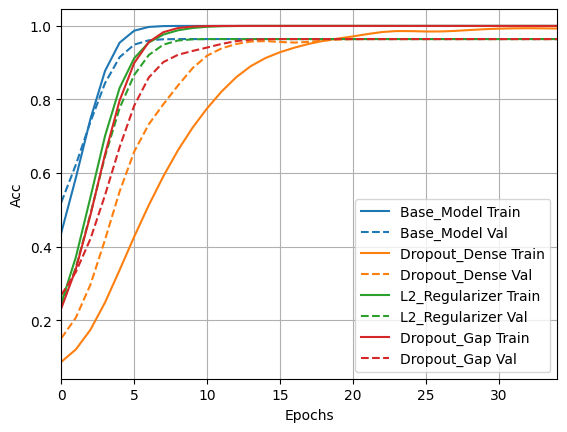

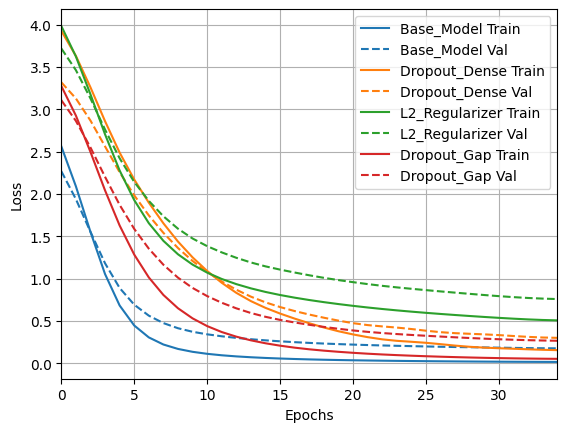

In [116]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

histories = {}
histories['base_model'] = history
histories['dropout_Dense'] = dropout50_history
histories['l2_regularizer'] = l2regularizer_history
histories['dropout_GAP'] = dropoutGAP_history

plt.figure(1)
plotter = tfdocs.plots.HistoryPlotter(metric = 'acc', smoothing_std=10)
plotter.plot(histories)

plt.figure(2)
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)


### Responda (2pt)

**ToDo** - com qual configuração conseguiu resolver o overfitting?

O Overfitting não foi observado de forma clara no modelo base, aquele sem as técnicas de regularização. No entanto, a aplicação do Dropout antes da camada GAP (Dropout_Gap) foi o que apresentou menor perda da função de custo na base de validação. No que tange a acurácia, ele também atingiu a mesma performance que o modelo base. 

Importante notar que todas as configurações de regularização requerem mais épocas de treinamento, pelas características intrínsecas dessas técnicas, para atingimente de performance comparável ao modelo sem regularização.